Middlemarch, by George Eliot, one of the great novels of the 19th Century, is out of copyright and available for free via Project Gutenberg (https://www.gutenberg.org/). To my shame, I have yet to read it. But what insights can we draw from text analysis? We apply a *topic modeling* approach to this task, utilizing the *Latent Dirichlet Allocation* (LDA) method.

As well as exploring and analysing the data, we verify the assertions of Maria Antoniak in her blog (https://maria-antoniak.github.io/2022/07/27/topic-modeling-for-the-people.html) on LDA:

1) It’s fine to use LDA -- we better take this as a given (for the purposes of this project)!

2) Evaluate the topics by hand -- not having access to human subjects(!), we cannot use either the word intruder or document intruder tests of Hoyle et al. (2021) and Chang et al. (2009) to evaluate the coherence of the resulting topics.

3) Test different numbers of topics -- we train our models with 10, 20, 30, 50, 100, and 200 topics to start, then use "qualitative evaluation" for optimization.

4) Longer documents are better -- this is good for us, as we are analysing the text of a book. Then again, "Documents that are too long (e.g., entire novels) can result in incoherent topics or topics that reflect different types of themes than topics trained on smaller documents." We need to be cognizant of this.

5) Tune the parameter controlling the topic distributions -- per Wallach et al. (2009), it’s helpful to tune the parameter governing topics per document distribution but not the parameter governing the words per topic distribution.

6) Train using Gibbs sampling -- the default sklearn package uses variational Bayes instead of Gibbs sampling. Instead, we'll use the tomotopy package. This also has the advantage of automated topic labelling.

7) Keep most stopwords -- this may seem counterintuitive, but Schofield et al. (2017) suggests it's the way to go. We run our models with and without stopwords, in order to compare the two.

8) Don't stem -- similarly, Schofield and Mimno (2016), found stemming and lemmatization methods are usually redundant and sometimes harmful, reducing the readability of your topics, lacking interpretability, and conflating terms with different meanings. Again, we run our models with and without stemming and lemmatization for comparison.

9) Remove duplicates -- while important when dealing with multiple documents, in our case we analyse a single (large) file, so need not worry about removing duplicates.

10) Consider your training set -- again, this is important when dealing with multiple documents, for instance Maria's example of online posts. But in analysing a book we need not worry about restricting the training dataset. 

11) Authorless Topic Models: Use what you already know -- we use the Authorless TMs package (available via MALLET) for preprocessing, to bias our topic models away from known metadata. 

12) Hand-label the topics -- we represent the top words for each topic, guided by domain knowledge. This notebook utilizes automatic topic labelling, but the exercise of labelling topics by hand is also useful. 
 
13) Visualisation tips -- Antoniak recommends heatmaps, and improving their legibility by ranking topics by entropy over subsets of the data, while also normalizing the columns. We use pyLDAvis for a wealth of in-built functionality.

***Exploratory data analysis***

We load the data and plot a histogram of the words appearing most frequently. 

Note: we borrow the code fragments to generate the histogram from George Chen's CMU course on Unstructured Data Analytics (https://www.andrew.cmu.edu/user/georgech/95-865/), which provided the inspiration to consider LDA.

In [1]:
#!pip install nltk
#!pip install --upgrade pip setuptools wheel
#!pip install tomotopy

In [2]:
import tomotopy as tp
print(tp.isa)

avx2


In [3]:
url = "https://www.gutenberg.org/cache/epub/145/pg145-images.html"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)
import spacy
nlp = spacy.load('en_core_web_sm')  # load spaCy's built-in English model

In [5]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [6]:
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')
print(html)

In [7]:
# Get the title
title = soup.title
print(title)

<title>
      Middlemarch | Project Gutenberg
    </title>


In [8]:
# Print out the text
text = soup.get_text()
print(soup.text)




      Middlemarch | Project Gutenberg
    


























The Project Gutenberg eBook of Middlemarch
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.
Title: Middlemarch

Author: George Eliot

Release date: July 1, 1994 [eBook #145]
                Most recently updated: June 7, 2024
Language: English

*** START OF THE PROJECT GUTENBERG EBOOK MIDDLEMARCH ***




Middlemarch
George Eliot
New York and Boston
H. M. Caldwell Company Publishers
To my dear Husband, George Henry Lewes,
in this nineteenth year of our blessed union.

Contents


 PRELUDE.


 BOOK I. MISS BROOKE.


 CHAPTER I.


 

In [9]:
type(soup.text)
nlp.max_length = 2000000 # or even higher
parsed_text = nlp(text)
type(parsed_text)

spacy.tokens.doc.Doc

In [10]:
# The vectorized approach
# No lemmatization, no stopwords
word_to_idx = {}  # key: vocabulary word
                  # value: unique integer index assigned to the vocabulary word (starting at 0)
current_word_idx = 0

for token in parsed_text:
    word = token.orth_
    if word not in word_to_idx:
        word_to_idx[word] = current_word_idx
        current_word_idx += 1

vocab_size = current_word_idx  # you can check that indeed `vocab_size` is equal to `len(word_to_idx)`
print(f'Found {vocab_size} vocabulary words')

Found 16991 vocabulary words


In [11]:
vocab = [''] * vocab_size
for word, idx in word_to_idx.items():
    vocab[idx] = word

#### Example: Representing different sentences each as its own feature vector of raw counts

In [12]:
sentence_feature_vectors = []
sentences = []
for sentence in parsed_text.sents:
    sentences.append(sentence.orth_)

    sentence_raw_counts = np.zeros(vocab_size)
    for token in sentence:
        word = token.orth_
        sentence_raw_counts[word_to_idx[word]] += 1
    sentence_feature_vectors.append(sentence_raw_counts)

In [13]:
word_to_idx = {}  # key: vocabulary word
                   # value: unique integer index assigned to the vocabulary word (starting at 0)
current_word_idx = 0

for token in parsed_text:
    word = token.lemma_.lower()
    if not (nlp.vocab[word].is_stop or token.pos_ == 'PUNCT' or token.pos_ == 'SPACE' or token.pos_ == 'X'):
        if word not in word_to_idx:
            word_to_idx[word] = current_word_idx
            current_word_idx += 1

vocab_size = current_word_idx  # you can check that indeed `vocab_size` is equal to `len(word_to_idx)`
print(f'Found {vocab_size} vocabulary words')

vocab = [''] * vocab_size
for word, idx in word_to_idx.items():
    vocab[idx] = word

one_hot_encoded_vectors = []
for token in parsed_text:
    word = token.lemma_.lower()
    if not (nlp.vocab[word].is_stop or token.pos_ == 'PUNCT' or token.pos_ == 'SPACE' or token.pos_ == 'X'):
        one_hot_encoded_vector = np.zeros(vocab_size)  # all zeros; length of vector is the vocabulary size
        one_hot_encoded_vector[word_to_idx[word]] = 1  # set the current word's index to have a value of 1

        one_hot_encoded_vectors.append(one_hot_encoded_vector)

one_hot_encoded_vectors = np.array(one_hot_encoded_vectors)  # convert Python list of 1D arrays into NumPy 2D array
raw_counts = one_hot_encoded_vectors.sum(axis=0)

Found 12025 vocabulary words


In [14]:
manual_stop_words = {'jump', 'b', '-', 'c'}
manual_stop_word_indices = [word_to_idx[word] for word in manual_stop_words]
#manual_stop_word_indices
vocab = [word for word in vocab if word not in manual_stop_words]
one_hot_encoded_vectors = np.delete(one_hot_encoded_vectors, manual_stop_word_indices, axis=1)
raw_counts = one_hot_encoded_vectors.sum(axis=0)
top_counts, top_words = zip(*sorted(zip(raw_counts, vocab), reverse=True))

Text(0, 0.5, 'Raw count')

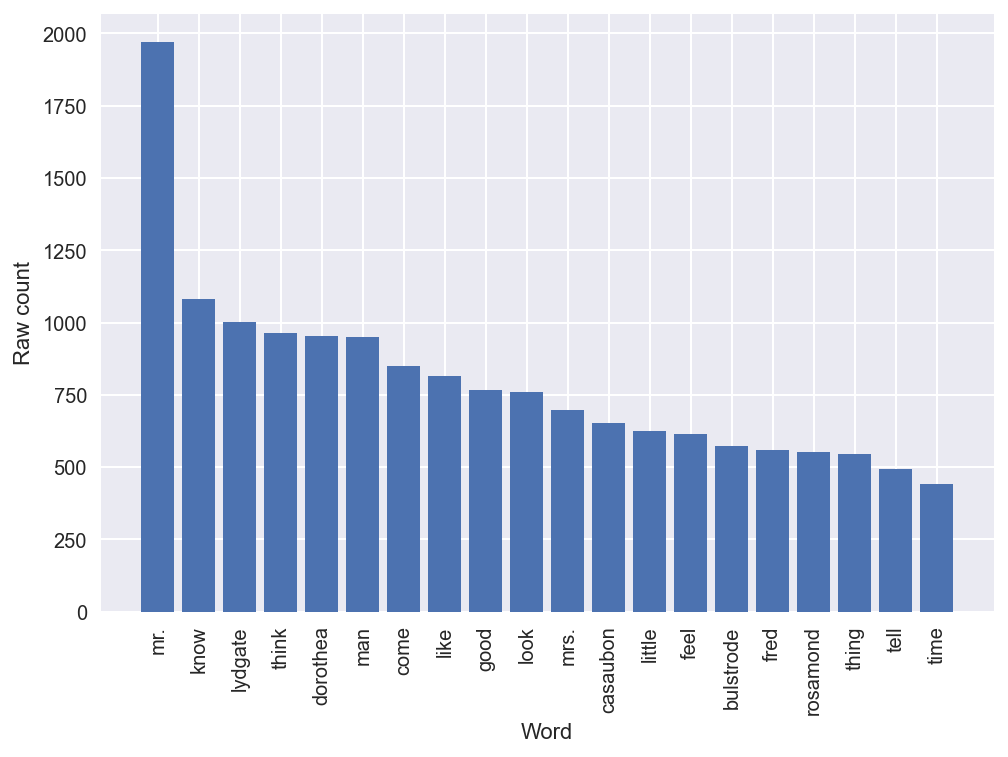

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')  # prettier plots (for example, use 'ggplot' instead of 'seaborn' for plots like in R)
%config InlineBackend.figure_format = 'retina'  # if you use a Mac with Retina display

num_top_words_to_plot = 20
plt.bar(range(num_top_words_to_plot), top_counts[:num_top_words_to_plot])
plt.xticks(range(num_top_words_to_plot), top_words[:num_top_words_to_plot], rotation=90)
plt.xlabel('Word')
plt.ylabel('Raw count')

### We now fit an LDA model to the data.

In [16]:
mdl = tp.LDAModel(k=20, min_df = 7)
for line in sentences:
    mdl.add_doc(line.strip().split())

for i in range(0, 100, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=10))

mdl.summary()

Iteration: 0	Log-likelihood: -7.87340693403019
Iteration: 10	Log-likelihood: -7.648807916502404
Iteration: 20	Log-likelihood: -7.537080554263512
Iteration: 30	Log-likelihood: -7.466346580892853
Iteration: 40	Log-likelihood: -7.417269710333234
Iteration: 50	Log-likelihood: -7.378874329542858
Iteration: 60	Log-likelihood: -7.338861611123428
Iteration: 70	Log-likelihood: -7.314713696780609
Iteration: 80	Log-likelihood: -7.295403638306812
Iteration: 90	Log-likelihood: -7.272246310810068
Top 10 words of topic #0
[('said', 0.15018212795257568), ('is', 0.03734773397445679), ('Mr.', 0.03678015619516373), ('you', 0.029742196202278137), ('with', 0.027017822489142418), ('Sir', 0.026790790259838104), ('Dorothea,', 0.021909624338150024), ('a', 0.021001501008868217), ('“I', 0.01895822212100029), ('very', 0.016687912866473198)]
Top 10 words of topic #1
[('he', 0.08427629619836807), ('not', 0.0830264538526535), ('to', 0.05570836365222931), ('that', 0.04874493181705475), ('was', 0.03847832977771759), (

Without stopword removal, we are left with the above nonsense topics. Below, we see that stopword removal provides meaningful topics. So, while this makes a clear case for stopword removal, I do not dispute the findings of Schofield et al. (2017). Indeed, the authors write "topic inference benefits little from the practice of removing stopwords **beyond very frequent terms**" [my emphasis].

In [17]:
import nltk
#nltk.download('stopwords')

# This code requires nltk package for stemming.
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

stemmer = PorterStemmer()
stopwords = set(stopwords.words('english'))
corpus = tp.utils.Corpus(tokenizer=tp.utils.SimpleTokenizer(stemmer=stemmer.stem), 
    stopwords=lambda x: len(x) <= 2 or x in stopwords)
# data_feeder yields a tuple of (raw string, user data) or a str (raw string)
corpus.process(sentences)

14018

In [18]:
def LDAk(K, D):
  # make LDA model and train
    mdl = tp.LDAModel(k=K, min_cf=10, min_df=D, corpus=corpus)
    mdl.train(0)
    print('Num docs:', len(mdl.docs), ', Vocab size:', mdl.num_vocabs, ', Num words:', mdl.num_words)
    print('Removed top words:', mdl.removed_top_words)
    for i in range(0, 1000, 10):
        mdl.train(10)
        print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

    # extract candidates for auto topic labeling
    extractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)
    cands = extractor.extract(mdl)

    labeler = tp.label.FoRelevance(mdl, cands, min_df=5, smoothing=1e-2, mu=0.25)
    for k in range(mdl.k):
        print("== Topic #{} ==".format(k))
        print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
        for word, prob in mdl.get_topic_words(k, top_n=10):
            print(word, prob, sep='\t')
        print()

LDAk(10, 5)

Num docs: 13967 , Vocab size: 2343 , Num words: 131738
Removed top words: []
Iteration: 0	Log-likelihood: -8.280175178573463
Iteration: 10	Log-likelihood: -8.124265474890198
Iteration: 20	Log-likelihood: -7.976100262724401
Iteration: 30	Log-likelihood: -7.883500695719031
Iteration: 40	Log-likelihood: -7.813806406421658
Iteration: 50	Log-likelihood: -7.758866011569982
Iteration: 60	Log-likelihood: -7.725515825958896
Iteration: 70	Log-likelihood: -7.691671786540404
Iteration: 80	Log-likelihood: -7.675648259520974
Iteration: 90	Log-likelihood: -7.6525288342846585
Iteration: 100	Log-likelihood: -7.629170128619889
Iteration: 110	Log-likelihood: -7.616784150281588
Iteration: 120	Log-likelihood: -7.607174008897501
Iteration: 130	Log-likelihood: -7.600645899022824
Iteration: 140	Log-likelihood: -7.584543431056903
Iteration: 150	Log-likelihood: -7.577827390732005
Iteration: 160	Log-likelihood: -7.576335907459189
Iteration: 170	Log-likelihood: -7.5719381083891095
Iteration: 180	Log-likelihood: -

In [19]:
LDAk(20,5)

Num docs: 13967 , Vocab size: 2343 , Num words: 131738
Removed top words: []
Iteration: 0	Log-likelihood: -8.524591094134282
Iteration: 10	Log-likelihood: -8.25639565184799
Iteration: 20	Log-likelihood: -8.109863251129154
Iteration: 30	Log-likelihood: -8.019468147495344
Iteration: 40	Log-likelihood: -7.955770528352784
Iteration: 50	Log-likelihood: -7.912734659551175
Iteration: 60	Log-likelihood: -7.884903536607587
Iteration: 70	Log-likelihood: -7.8522254223676065
Iteration: 80	Log-likelihood: -7.827511564209322
Iteration: 90	Log-likelihood: -7.801038713055118
Iteration: 100	Log-likelihood: -7.788419124350997
Iteration: 110	Log-likelihood: -7.778330788082377
Iteration: 120	Log-likelihood: -7.769989700944358
Iteration: 130	Log-likelihood: -7.748350599625234
Iteration: 140	Log-likelihood: -7.742252047663242
Iteration: 150	Log-likelihood: -7.736595715531176
Iteration: 160	Log-likelihood: -7.724933959639511
Iteration: 170	Log-likelihood: -7.718513893035326
Iteration: 180	Log-likelihood: -7.

In [20]:
LDAk(30,5)

Num docs: 13967 , Vocab size: 2343 , Num words: 131738
Removed top words: []
Iteration: 0	Log-likelihood: -8.665572779480565
Iteration: 10	Log-likelihood: -8.363642992062314
Iteration: 20	Log-likelihood: -8.209083428470231
Iteration: 30	Log-likelihood: -8.11044564852091
Iteration: 40	Log-likelihood: -8.04377298948561
Iteration: 50	Log-likelihood: -8.003019200496631
Iteration: 60	Log-likelihood: -7.97181707344401
Iteration: 70	Log-likelihood: -7.93381480412197
Iteration: 80	Log-likelihood: -7.914899945523777
Iteration: 90	Log-likelihood: -7.896159614773417
Iteration: 100	Log-likelihood: -7.881715039225169
Iteration: 110	Log-likelihood: -7.866518559741131
Iteration: 120	Log-likelihood: -7.863504831200461
Iteration: 130	Log-likelihood: -7.852164683706889
Iteration: 140	Log-likelihood: -7.849073815065518
Iteration: 150	Log-likelihood: -7.843514307825976
Iteration: 160	Log-likelihood: -7.832881934202306
Iteration: 170	Log-likelihood: -7.832235369356875
Iteration: 180	Log-likelihood: -7.8266

In [21]:
LDAk(50,5)

Num docs: 13967 , Vocab size: 2343 , Num words: 131738
Removed top words: []
Iteration: 0	Log-likelihood: -8.826460845933482
Iteration: 10	Log-likelihood: -8.503616176781911
Iteration: 20	Log-likelihood: -8.338572368260374
Iteration: 30	Log-likelihood: -8.248405598507246
Iteration: 40	Log-likelihood: -8.173804112403001
Iteration: 50	Log-likelihood: -8.13126071511339
Iteration: 60	Log-likelihood: -8.116112433526968
Iteration: 70	Log-likelihood: -8.090541809466094
Iteration: 80	Log-likelihood: -8.070901909994177
Iteration: 90	Log-likelihood: -8.046600314007042
Iteration: 100	Log-likelihood: -8.021166910722087
Iteration: 110	Log-likelihood: -8.015047508686562
Iteration: 120	Log-likelihood: -8.00946578637043
Iteration: 130	Log-likelihood: -8.001971730499513
Iteration: 140	Log-likelihood: -7.983692631474062
Iteration: 150	Log-likelihood: -7.984901234871556
Iteration: 160	Log-likelihood: -7.971786561830512
Iteration: 170	Log-likelihood: -7.970080680154216
Iteration: 180	Log-likelihood: -7.96

In [22]:
LDAk(100,5)

Num docs: 13967 , Vocab size: 2343 , Num words: 131738
Removed top words: []
Iteration: 0	Log-likelihood: -9.107074224618957
Iteration: 10	Log-likelihood: -8.752052377238044
Iteration: 20	Log-likelihood: -8.58318197377325
Iteration: 30	Log-likelihood: -8.479322688464348
Iteration: 40	Log-likelihood: -8.411857875138303
Iteration: 50	Log-likelihood: -8.364383864024344
Iteration: 60	Log-likelihood: -8.325462129307118
Iteration: 70	Log-likelihood: -8.308730725846155
Iteration: 80	Log-likelihood: -8.297322022205266
Iteration: 90	Log-likelihood: -8.270619584131785
Iteration: 100	Log-likelihood: -8.254026746668075
Iteration: 110	Log-likelihood: -8.254822803350988
Iteration: 120	Log-likelihood: -8.244631020743528
Iteration: 130	Log-likelihood: -8.229634185718187
Iteration: 140	Log-likelihood: -8.23164900957368
Iteration: 150	Log-likelihood: -8.227241633808227
Iteration: 160	Log-likelihood: -8.211837399872147
Iteration: 170	Log-likelihood: -8.192797092418093
Iteration: 180	Log-likelihood: -8.18

In [23]:
LDAk(200,5)

Num docs: 13967 , Vocab size: 2343 , Num words: 131738
Removed top words: []
Iteration: 0	Log-likelihood: -9.51255786372946
Iteration: 10	Log-likelihood: -9.144640609145346
Iteration: 20	Log-likelihood: -8.97257697647307
Iteration: 30	Log-likelihood: -8.86474743464231
Iteration: 40	Log-likelihood: -8.808686444005554
Iteration: 50	Log-likelihood: -8.75103367807783
Iteration: 60	Log-likelihood: -8.712177598211637
Iteration: 70	Log-likelihood: -8.692069953891874
Iteration: 80	Log-likelihood: -8.66847871515536
Iteration: 90	Log-likelihood: -8.645684223035767
Iteration: 100	Log-likelihood: -8.617817818923042
Iteration: 110	Log-likelihood: -8.60012921912143
Iteration: 120	Log-likelihood: -8.575977495407116
Iteration: 130	Log-likelihood: -8.566574271712962
Iteration: 140	Log-likelihood: -8.544377615621064
Iteration: 150	Log-likelihood: -8.528112714167083
Iteration: 160	Log-likelihood: -8.535080438032564
Iteration: 170	Log-likelihood: -8.505247465853182
Iteration: 180	Log-likelihood: -8.504172

200 topics leave the above cell difficult to interpret by hand, and the topics overlap significantly. For instance, topics 0 and 5 both concern 'life'. While a choice of k = 20 or 30 topics hits a workable middle ground, I prefer to set k = 10 for ease of comparison as we tune other hyperparameters governing the LDA model.

In [24]:
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))
corpus = tp.utils.Corpus(tokenizer=tp.utils.SimpleTokenizer(stemmer=None), 
    stopwords=lambda x: len(x) <= 2 or x in stopwords)
# data_feeder yields a tuple of (raw string, user data) or a str (raw string)
corpus.process(sentences)

# make LDA model and train
mdl = tp.LDAModel(k=10, min_cf=10, min_df=5, corpus=corpus)
mdl.train(0)
print('Num docs:', len(mdl.docs), ', Vocab size:', mdl.num_vocabs, ', Num words:', mdl.num_words)
print('Removed top words:', mdl.removed_top_words)
for i in range(0, 1000, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)
cands = extractor.extract(mdl)

labeler = tp.label.FoRelevance(mdl, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(mdl.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in mdl.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

Num docs: 13963 , Vocab size: 2490 , Num words: 116037
Removed top words: []
Iteration: 0	Log-likelihood: -8.35145839478206
Iteration: 10	Log-likelihood: -8.166828294280718
Iteration: 20	Log-likelihood: -8.032894875736014
Iteration: 30	Log-likelihood: -7.942955855247639
Iteration: 40	Log-likelihood: -7.871145987289906
Iteration: 50	Log-likelihood: -7.816989225182595
Iteration: 60	Log-likelihood: -7.776570837146536
Iteration: 70	Log-likelihood: -7.7471875240641435
Iteration: 80	Log-likelihood: -7.723053983508073
Iteration: 90	Log-likelihood: -7.703200297863486
Iteration: 100	Log-likelihood: -7.691111642272851
Iteration: 110	Log-likelihood: -7.6743477587413285
Iteration: 120	Log-likelihood: -7.666209951607266
Iteration: 130	Log-likelihood: -7.6572614599533955
Iteration: 140	Log-likelihood: -7.642477594756028
Iteration: 150	Log-likelihood: -7.6374908052781985
Iteration: 160	Log-likelihood: -7.629173257070366
Iteration: 170	Log-likelihood: -7.626020404470399
Iteration: 180	Log-likelihood: 

Comparing the (immediately) above cell with that above (with k=10) and stemming, we see that indeed topics are more coherent **without** stemming, and there are fewer words appearing across multiple topics. (Note: restarting the kernel, one may recover different topics, but this conclusion should hold nonetheless.)

Next we vary min_df, leaving min_cf fixed (to answer Q5):

In [25]:
LDAk(10,0)

Num docs: 13963 , Vocab size: 2490 , Num words: 116037
Removed top words: []
Iteration: 0	Log-likelihood: -8.335406531052696
Iteration: 10	Log-likelihood: -8.160053552631217
Iteration: 20	Log-likelihood: -8.010012365689562
Iteration: 30	Log-likelihood: -7.922448408536942
Iteration: 40	Log-likelihood: -7.851500410297367
Iteration: 50	Log-likelihood: -7.804281795935453
Iteration: 60	Log-likelihood: -7.768236490443116
Iteration: 70	Log-likelihood: -7.732113099035692
Iteration: 80	Log-likelihood: -7.702557208536525
Iteration: 90	Log-likelihood: -7.681665799512044
Iteration: 100	Log-likelihood: -7.665415572649288
Iteration: 110	Log-likelihood: -7.658053734320664
Iteration: 120	Log-likelihood: -7.644318852888095
Iteration: 130	Log-likelihood: -7.628326735179679
Iteration: 140	Log-likelihood: -7.626602636111157
Iteration: 150	Log-likelihood: -7.6176805051270335
Iteration: 160	Log-likelihood: -7.61496044176276
Iteration: 170	Log-likelihood: -7.597313484418563
Iteration: 180	Log-likelihood: -7.

In [26]:
LDAk(10,2)

Num docs: 13963 , Vocab size: 2490 , Num words: 116037
Removed top words: []
Iteration: 0	Log-likelihood: -8.327804618494294
Iteration: 10	Log-likelihood: -8.131976799486493
Iteration: 20	Log-likelihood: -8.015154688145257
Iteration: 30	Log-likelihood: -7.931118676697416
Iteration: 40	Log-likelihood: -7.864435535244317
Iteration: 50	Log-likelihood: -7.820600254648354
Iteration: 60	Log-likelihood: -7.782771488884727
Iteration: 70	Log-likelihood: -7.751551891791574
Iteration: 80	Log-likelihood: -7.716837290173203
Iteration: 90	Log-likelihood: -7.705213139187159
Iteration: 100	Log-likelihood: -7.69985636272073
Iteration: 110	Log-likelihood: -7.683206811164211
Iteration: 120	Log-likelihood: -7.6711863521414445
Iteration: 130	Log-likelihood: -7.656925680043312
Iteration: 140	Log-likelihood: -7.645699588725313
Iteration: 150	Log-likelihood: -7.6397825712471885
Iteration: 160	Log-likelihood: -7.631272167472072
Iteration: 170	Log-likelihood: -7.618045385739376
Iteration: 180	Log-likelihood: -7

In [27]:
LDAk(10,4)

Num docs: 13963 , Vocab size: 2490 , Num words: 116037
Removed top words: []
Iteration: 0	Log-likelihood: -8.35513712867491
Iteration: 10	Log-likelihood: -8.188497488801772
Iteration: 20	Log-likelihood: -8.048829060197118
Iteration: 30	Log-likelihood: -7.947957517982605
Iteration: 40	Log-likelihood: -7.872820536320229
Iteration: 50	Log-likelihood: -7.817490513228147
Iteration: 60	Log-likelihood: -7.77736058260554
Iteration: 70	Log-likelihood: -7.724675581478027
Iteration: 80	Log-likelihood: -7.695756289257169
Iteration: 90	Log-likelihood: -7.676717274723951
Iteration: 100	Log-likelihood: -7.6594576878667535
Iteration: 110	Log-likelihood: -7.647967019123914
Iteration: 120	Log-likelihood: -7.6391138007461015
Iteration: 130	Log-likelihood: -7.633675732437742
Iteration: 140	Log-likelihood: -7.626173596157714
Iteration: 150	Log-likelihood: -7.614873153641529
Iteration: 160	Log-likelihood: -7.610526663338794
Iteration: 170	Log-likelihood: -7.610127962915037
Iteration: 180	Log-likelihood: -7.

In [28]:
LDAk(10,6)

Num docs: 13963 , Vocab size: 2490 , Num words: 116037
Removed top words: []
Iteration: 0	Log-likelihood: -8.331025536801794
Iteration: 10	Log-likelihood: -8.154695410910376
Iteration: 20	Log-likelihood: -8.005750390718083
Iteration: 30	Log-likelihood: -7.907762158394941
Iteration: 40	Log-likelihood: -7.850659385844
Iteration: 50	Log-likelihood: -7.802929569169804
Iteration: 60	Log-likelihood: -7.759779909206094
Iteration: 70	Log-likelihood: -7.720215801411931
Iteration: 80	Log-likelihood: -7.699649580911161
Iteration: 90	Log-likelihood: -7.677799296445661
Iteration: 100	Log-likelihood: -7.667297195898769
Iteration: 110	Log-likelihood: -7.651070779931607
Iteration: 120	Log-likelihood: -7.637209194565504
Iteration: 130	Log-likelihood: -7.621641921061242
Iteration: 140	Log-likelihood: -7.6200547269120795
Iteration: 150	Log-likelihood: -7.609310495140913
Iteration: 160	Log-likelihood: -7.60247718719799
Iteration: 170	Log-likelihood: -7.603331344264363
Iteration: 180	Log-likelihood: -7.592

In [29]:
LDAk(10,8)

Num docs: 13963 , Vocab size: 2489 , Num words: 116027
Removed top words: []
Iteration: 0	Log-likelihood: -8.341621985015175
Iteration: 10	Log-likelihood: -8.15506956223188
Iteration: 20	Log-likelihood: -8.024242143648262
Iteration: 30	Log-likelihood: -7.926549212617136
Iteration: 40	Log-likelihood: -7.857358906870057
Iteration: 50	Log-likelihood: -7.8038716087368885
Iteration: 60	Log-likelihood: -7.777235703223507
Iteration: 70	Log-likelihood: -7.735174507891337
Iteration: 80	Log-likelihood: -7.717109107434206
Iteration: 90	Log-likelihood: -7.689951559548085
Iteration: 100	Log-likelihood: -7.678996929153989
Iteration: 110	Log-likelihood: -7.668988227608444
Iteration: 120	Log-likelihood: -7.654784769383353
Iteration: 130	Log-likelihood: -7.636001992503001
Iteration: 140	Log-likelihood: -7.636069983947473
Iteration: 150	Log-likelihood: -7.62312986117397
Iteration: 160	Log-likelihood: -7.6161247265201535
Iteration: 170	Log-likelihood: -7.608920477729647
Iteration: 180	Log-likelihood: -7.

In [30]:
LDAk(10,10)

Num docs: 13963 , Vocab size: 2464 , Num words: 115771
Removed top words: []
Iteration: 0	Log-likelihood: -8.348676008705983
Iteration: 10	Log-likelihood: -8.18360750451561
Iteration: 20	Log-likelihood: -8.03584298743677
Iteration: 30	Log-likelihood: -7.938181685396999
Iteration: 40	Log-likelihood: -7.867748555975854
Iteration: 50	Log-likelihood: -7.812183018712366
Iteration: 60	Log-likelihood: -7.774685486742227
Iteration: 70	Log-likelihood: -7.747547657918172
Iteration: 80	Log-likelihood: -7.72254624504256
Iteration: 90	Log-likelihood: -7.695031585163919
Iteration: 100	Log-likelihood: -7.67660561040878
Iteration: 110	Log-likelihood: -7.672387847159851
Iteration: 120	Log-likelihood: -7.664411268520736
Iteration: 130	Log-likelihood: -7.653114147351407
Iteration: 140	Log-likelihood: -7.645420255440094
Iteration: 150	Log-likelihood: -7.635306156083399
Iteration: 160	Log-likelihood: -7.626577859250158
Iteration: 170	Log-likelihood: -7.618640384223548
Iteration: 180	Log-likelihood: -7.6243

There appears to be little impact on topics' coherence upon varying the parameter min_df, which governs topics per document distribution. That said, this by no means calls into question the findings of Wallach et al. (2009). finidings. For simplicity, we'll continue with our original setting of min_df = 5.

In [31]:
#!pip install pyldavis==3.2.2

In [32]:
import pyLDAvis
mdl.summary()

topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    n_jobs=1,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)

pyLDAvis.enable_notebook()
pyLDAvis.display(prepared_data)

<Basic Info>
| LDAModel (current version: 0.11.1)
| 13963 docs, 116037 words
| Total Vocabs: 19089, Used Vocabs: 2490
| Entropy of words: -7.08516
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.52477
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 10 (minimum collection frequency of words)
| min_df: 5 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 10 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 467075329 (random seed)
| trained in version 0.11.1
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.71974 0.30524 0.18491 0.48506 0.38446 0.54124

/Library/Python/3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


**Concluding remarks**

None of the above analysis adequately substitutes for reading the book itself! Nonetheless, I have found the exercise useful, and succeeded in verifying the majority of Maria Antoniak's 13 recommendations. In particular, I have learned to train LDA models using the tomotopy (or gensim) package rather than sklearn, and to use the pyLDAvis package for impressive visual outputs. Ultimately, I am dissuaded from LDA topic modeling by the necessity of having human subjects for word intruder/document intruder tests of coherence. However, these methods are welcome additions to my unstructured data analysis toolkit, and I may use them going forward as part of a detailed exploratory data analysis. 